In [1]:
#Import Statements
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
#Load train and test data
train_data = CIFAR10(
    root='../data',          
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = CIFAR10(
    root='../data',
    train=False,
    download = True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Split train_data into training/validation datasets
def split_train_data(len_dataset, split_percent = 0.1, seed = 99):
    num_of_valid = int(len_dataset * split_percent)
    np.random.seed(seed)
    idxs = np.random.permutation(len_dataset)
    return idxs[num_of_valid:], idxs[:num_of_valid]

In [5]:
split_percent = 0.2
random_seed = 42

train_indices, valid_indices = split_train_data(len(train_data), split_percent, random_seed)

In [6]:
#Random Data Loader for batch training
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(train_data, batch_size, sampler = train_sampler)

valid_sampler = SubsetRandomSampler(valid_indices)
valid_dl = DataLoader(train_data, batch_size, sampler = valid_sampler)

In [7]:
#Tri-layer CNN 
class custom_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [8]:
#Device management for optimal learning rate
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return[to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, device)
    def __len__(self):
        return len(self.dl)

In [9]:
device = get_default_device()
model = custom_CNN(10)
model = model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [10]:
#Gradient Descent Algorithm
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  preds = model(xb)
  loss = loss_func(preds, yb)
  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()
  metric_result=None
  if metric:
    metric_result = metric(preds, yb)
  return loss.item(), len(xb), metric_result

In [11]:
#Validation set testing
def evaluate(model, loss_func, valid_dl, metric = None):
  with torch.no_grad():
    results = [loss_batch(model, loss_func, xb, yb, metric=metric) for xb, yb in valid_dl]

    losses, nums, metrics = zip(*results)

    total = np.sum(nums)

    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    if metric:
      avg_metric = np.sum(np.multiply(metrics, nums))/total
    return avg_loss, total, avg_metric

In [12]:
#Iterative learning function
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric = None, opt_fn = None):
  train_losses, val_losses, val_metrics = [], [], []
  if not opt_fn:
    opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr = lr)

  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
    
    model.eval()
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

    if not metric:
      print('Epoch[{}/{}], train_loss: {:4f}, val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
    else:
      print('Epoch[{}/{}], train_loss: {:.4f}, val_loss{:.4f},val_{}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__,val_metric))
  return train_losses, val_losses, val_metrics


In [13]:
#Human-understandable measurement
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.sum(preds == labels).item()/len(preds)

In [20]:
#Hyperparameters
num_epochs = 20
opt_fn = torch.optim.Adam
lr = 0.001

In [21]:
#Model Training
history = fit(num_epochs, lr, model, F.cross_entropy, train_dl, valid_dl, metric = accuracy, opt_fn = opt_fn)
train_losses, val_losses, val_metrics = history

Epoch[1/20], train_loss: 0.7549, val_loss0.9340,val_accuracy: 0.6881
Epoch[2/20], train_loss: 0.8774, val_loss0.9345,val_accuracy: 0.6907
Epoch[3/20], train_loss: 0.4853, val_loss0.9453,val_accuracy: 0.6919
Epoch[4/20], train_loss: 0.6235, val_loss0.9446,val_accuracy: 0.6917
Epoch[5/20], train_loss: 0.5725, val_loss0.9567,val_accuracy: 0.6908
Epoch[6/20], train_loss: 0.6459, val_loss0.9615,val_accuracy: 0.6929
Epoch[7/20], train_loss: 0.5240, val_loss0.9715,val_accuracy: 0.6923
Epoch[8/20], train_loss: 0.4645, val_loss0.9924,val_accuracy: 0.6908
Epoch[9/20], train_loss: 0.3738, val_loss0.9943,val_accuracy: 0.6917
Epoch[10/20], train_loss: 0.5766, val_loss1.0142,val_accuracy: 0.6892
Epoch[11/20], train_loss: 0.5053, val_loss1.0292,val_accuracy: 0.6909
Epoch[12/20], train_loss: 0.5268, val_loss1.0439,val_accuracy: 0.6864
Epoch[13/20], train_loss: 0.4770, val_loss1.0461,val_accuracy: 0.6896
Epoch[14/20], train_loss: 0.6324, val_loss1.0744,val_accuracy: 0.6884
Epoch[15/20], train_loss: 0.4

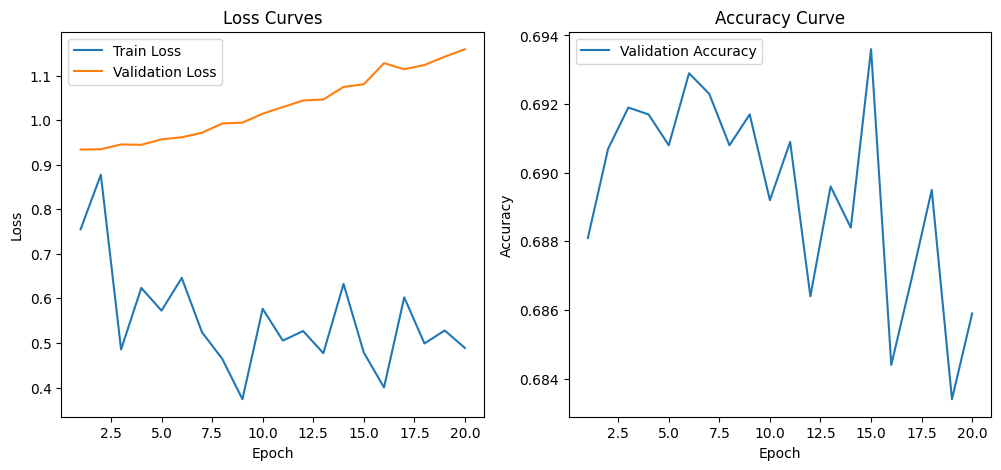

In [22]:
#Graph plots for model results
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(epochs, val_metrics, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

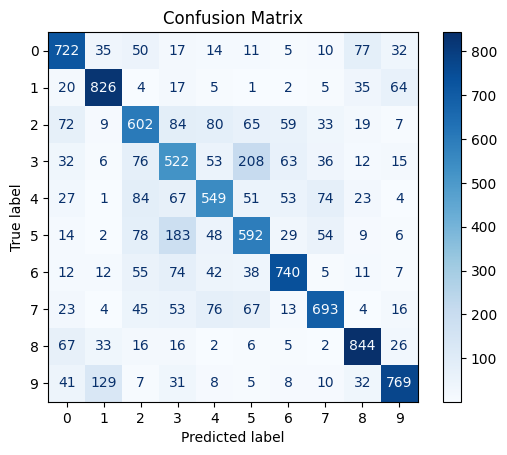

In [23]:
#Confusion Matrix for validation set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for xb, yb in valid_dl:
        preds = model(xb)
        _, predicted = torch.max(preds, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Test Loss: 1.2027, Test Accuracy: 0.6753


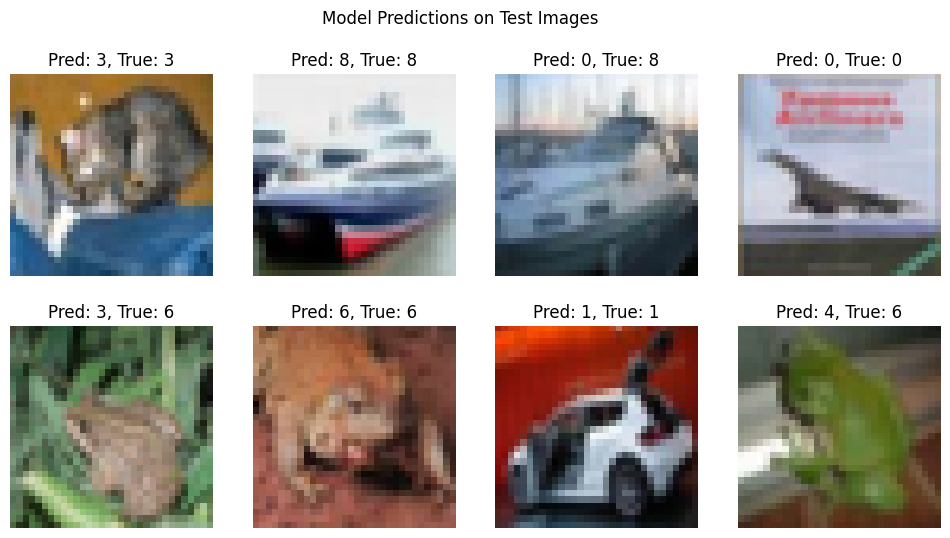

In [24]:
#Evaluation on Test_data
test_dl = DataLoader(test_data, batch_size=100, shuffle=False)
test_dl = DeviceDataLoader(test_dl, device)

test_loss, _, test_acc = evaluate(model, F.cross_entropy, test_dl, metric=accuracy)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

model.eval()
images_shown = 0
plt.figure(figsize=(12, 6))
with torch.no_grad():
    for images, labels in test_dl:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        images = images.cpu()
        for i in range(min(8, images.size(0))):
            plt.subplot(2, 4, images_shown + 1)
            plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
            plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
            plt.axis('off')
            images_shown += 1
            if images_shown == 8:
                break
        if images_shown == 8:
            break
plt.suptitle("Model Predictions on Test Images")
plt.show()

In [25]:
#Save Model as .pth
torch.save(model.state_dict(), "custom_cnn_model.pth")